In [1]:
import keras
import sys
sys.path.append('C:/Users/320060820/experiments/')
import os
import fxp_quantize
import model_data

from model_gen import inception_cnn
import copy

import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tnrange, tqdm_notebook

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
def brute_force_analysis(model_obj, name, test_data, layer_names, bw_range, f_range, 
                         float_model_acc, fix_quant=False, parameters=None, eval_metric='acc_drop'):
    
    if fix_quant and parameters is None:
        raise ValueError('parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
        
    for i in range(len(layer_names)):
        
        scores_matrix = []
        
        for j in tnrange(len(bw_range), desc=f'BW Layer {layer_names[i]}', leave=False):
            
            scores_row = []
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):
                
                quant_params = {
                    layer_names[i]: [bw_range[j], f_range[k]]
                }
                if fix_quant:
                    quant_params = {**quant_params, **parameters}
                
                df_model = model_data.Model(name, test_data, model=model_obj.get_fxp_model(quant_params))
                scores_row.append(df_model.evaluate_accuracy()[1])
                
            scores_matrix.append(scores_row)
            
        scores = np.array(scores_matrix)

        if i == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {layer_names[i]} done.')
    
    if eval_metric == 'acc_drop':
        model_scores = (float_model_acc - model_scores) / float_model_acc
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / float_model_acc
        
    elif eval_metric == 'quant_acc':
        pass
    
    return model_scores

In [3]:
def plot_results(scores, layer_names, rows, columns, figsize, shrink, bw_range, f_range, invert=False, vmax=None):
    
    if len(scores.shape) < 3:
        scores = np.expand_dims(scores, axis=3)
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    cbar_ax = fig.add_axes([.91, 0.1, .02, 0.8])
    if rows == 1 and columns == 1:
        ax = [ax]
    else:
        ax = ax.flatten()
    vmin = scores.min()
    if vmax is None:
        vmax = scores.max()
    else:
        vmax=vmax
    t = np.arange(0.0, vmax, 0.1).tolist()
    for i in range(scores.shape[2]):
        sns.heatmap(scores[:, :, i], annot=True, fmt='.3f', ax=ax[i], xticklabels=f_range, 
                    yticklabels=bw_range, vmin = vmin, vmax=vmax, cbar_ax=cbar_ax)#, cbar_kws={"ticks":t})
#         sns.heatmap(scores[:, :, i], annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_ax=cbar_ax)
        ax[i].set_xlabel('Fractional offset')
        ax[i].set_ylabel('Bitwidth')
        ax[i].set_title(f'Layer {layer_names[i]}')
        if invert:
            ax[i].invert_yaxis()
    if rows*columns - scores.shape[2] != 0:
        for i in range(1, rows*columns - scores.shape[2] + 1):
            fig.delaxes(ax[-i])

In [4]:
input_shape = (96, 96, 3)
num_outputs = 10 # number of classes
path_trained_weights = 'C:/Users/320060820/experiments/test_models/svhn_df/svhn_df_w.h5'
output_path = 'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/Activations/DF_SVHN/'
name = 'svhn_df'

from test_models.svhn_df import data
_, test_data = data.get_data()

df_svhn = inception_cnn.InceptionCNN(input_shape, num_outputs, dropout=True,
                                      pool_layer_type='max',
                                     path_trained_weights=path_trained_weights)

In [ ]:
layer_names = ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_10', 'conv2d_11', 
               'conv2d_16', 'conv2d_17', 'conv2d_19', 'conv2d_20'] + ['binary']

In [5]:
bw_range = np.arange(1, 9, 1)
f_range = np.arange(-4, 7, 1)
t_layer_names = ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_12', 'conv2d_13', 'conv2d_16', 'conv2d_20', 'binary']

In [6]:
model = model_data.Model(name, test_data, model=df_svhn.get_float_model())
float_model_acc = model.evaluate_accuracy()[1]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
scores_1 = brute_force_analysis(df_svhn, name, test_data, t_layer_names, bw_range, f_range, float_model_acc)
np.save(output_path + 'scores_1', arr=scores_1)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_16 done.


Layer conv2d_20 done.


Layer binary done.


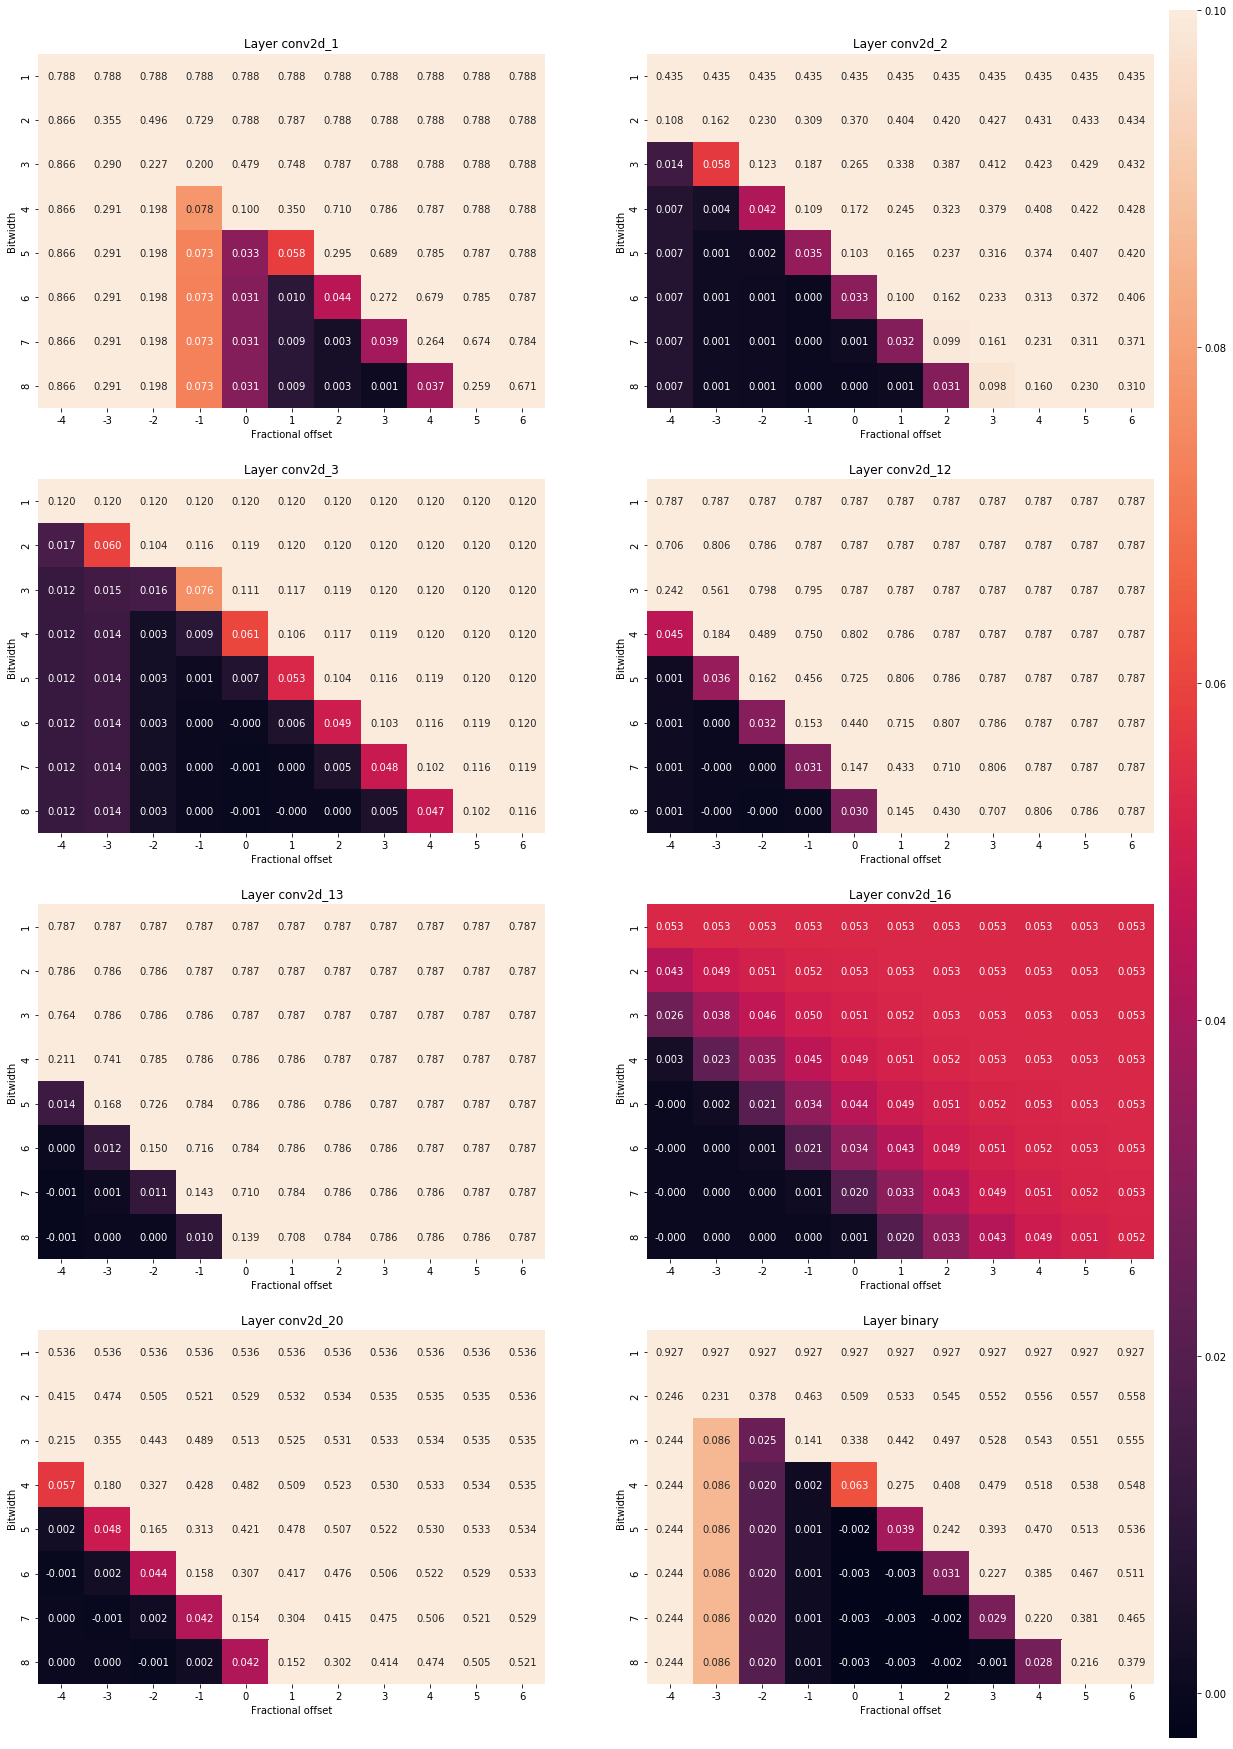

In [12]:
plot_results(scores_1, t_layer_names, 4, 2, (20, 30), 0.8, bw_range, f_range, vmax=0.1)